In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.utils import shuffle
import sklearn
from sklearn.decomposition import TruncatedSVD

import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

# Combine fashion and electronics

In [95]:
elec = pd.read_csv("electronics/electronics_processed.csv")
elec.head()

,Unnamed: 0,reviewerID,asin,overall,new_user_id,new_product_id
0,0,A2CX7LUOHB2NDG,0321732944,5.0,0,0
1,1,A2NWSAGRHCP8N5,0439886341,1.0,1,1
2,2,A2WNBOD3WNDNKT,0439886341,3.0,2,1
3,3,A1GI0U4ZRJA8WN,0439886341,1.0,3,1
4,4,A1QGNMC6O1VW39,0511189877,5.0,4,2


In [96]:
len(elec)

7824481

In [97]:
elec = elec[["reviewerID", "asin", "overall"]]

In [98]:
fash = pd.read_csv("fashion/fashion_processed.csv")
fash.head()

,Unnamed: 0,reviewerID,asin,overall,new_user_id,new_product_id
0,0,A1D4G1SNUZWQOT,7106116521,5.0,0,0
1,1,A3DDWDH9PX2YX2,7106116521,2.0,1,0
2,2,A2MWC41EW7XL15,7106116521,4.0,2,0
3,3,A2UH2QQ275NV45,7106116521,2.0,3,0
4,4,A89F3LQADZBS5,7106116521,3.0,4,0


In [99]:
fash = fash[["reviewerID", "asin", "overall"]]
fash.tail()

,reviewerID,asin,overall
875116,A1ZSB2Q144UTEY,B01HJHTH5U,5.0
875117,A2CCDV0J5VB6F2,B01HJHTH5U,5.0
875118,A3O90PACS7B61K,B01HJHTH5U,3.0
875119,A2HO94I89U3LNH,B01HJHF97K,3.0
875120,A2RSX9E79DUHRX,B01HJG5NMW,5.0


In [100]:
len(fash)

875121

In [101]:
df = elec.append(fash, ignore_index=True)
df.head()

,reviewerID,asin,overall
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [102]:
df.tail()

,reviewerID,asin,overall
8699597,A1ZSB2Q144UTEY,B01HJHTH5U,5.0
8699598,A2CCDV0J5VB6F2,B01HJHTH5U,5.0
8699599,A3O90PACS7B61K,B01HJHTH5U,3.0
8699600,A2HO94I89U3LNH,B01HJHF97K,3.0
8699601,A2RSX9E79DUHRX,B01HJG5NMW,5.0


In [103]:
df['index'] = np.arange(df.shape[0])
df.head()

,reviewerID,asin,overall,index
0,A2CX7LUOHB2NDG,0321732944,5.0,0
1,A2NWSAGRHCP8N5,0439886341,1.0,1
2,A2WNBOD3WNDNKT,0439886341,3.0,2
3,A1GI0U4ZRJA8WN,0439886341,1.0,3
4,A1QGNMC6O1VW39,0511189877,5.0,4


In [104]:
df['is_elec']= np.where(df['index'] < 7824481 , 1, 0)
df.head()

,reviewerID,asin,overall,index,is_elec
0,A2CX7LUOHB2NDG,0321732944,5.0,0,1
1,A2NWSAGRHCP8N5,0439886341,1.0,1,1
2,A2WNBOD3WNDNKT,0439886341,3.0,2,1
3,A1GI0U4ZRJA8WN,0439886341,1.0,3,1
4,A1QGNMC6O1VW39,0511189877,5.0,4,1


In [105]:
# give new_user_id based on reviewerID

current_user_id = 0
custom_user_map = {} 
def map_user_id(row):
    global current_user_id, custom_user_map
    old_user_id = row["reviewerID"]
    if old_user_id not in custom_user_map:
        custom_user_map[old_user_id] = current_user_id
        current_user_id += 1
    return custom_user_map[old_user_id]

df["new_user_id"] = df.apply(map_user_id, axis=1)

In [106]:
# give new_product_id based on asin

current_product_id = 0
custom_product_map = {} 
def map_product_id(row):
    global current_product_id, custom_product_map
    old_product_id = row["asin"]
    if old_product_id not in custom_product_map:
        custom_product_map[old_product_id] = current_product_id
        current_product_id += 1
    return custom_product_map[old_product_id]

df["new_product_id"] = df.apply(map_product_id, axis=1)

In [107]:
df[df["reviewerID"]=="A3BMUBUC1N77U8"]

,reviewerID,asin,overall,index,is_elec,new_user_id,new_product_id
199,A3BMUBUC1N77U8,0972683275,4.0,199,1,199,37
448822,A3BMUBUC1N77U8,B0002BEQNE,5.0,448822,1,199,27845
476901,A3BMUBUC1N77U8,B0002JEUOQ,5.0,476901,1,199,29803
607016,A3BMUBUC1N77U8,B0007PCB6O,5.0,607016,1,199,36975
621049,A3BMUBUC1N77U8,B0007U9SRE,5.0,621049,1,199,37652
1106146,A3BMUBUC1N77U8,B000K52D0K,5.0,1106146,1,199,64667
1148433,A3BMUBUC1N77U8,B000M2TAN4,5.0,1148433,1,199,67907
1352851,A3BMUBUC1N77U8,B000SBLM1C,3.0,1352851,1,199,78655
1429043,A3BMUBUC1N77U8,B000V6R2OU,5.0,1429043,1,199,82255
1612156,A3BMUBUC1N77U8,B0012S4APK,5.0,1612156,1,199,92805


In [ ]:
df.to_csv('elec_fash.csv')

# Information about data

In [109]:
df = pd.read_csv("elec_fash.csv")
df.head()

,Unnamed: 0,reviewerID,asin,overall,index,is_elec,new_user_id,new_product_id
0,0,A2CX7LUOHB2NDG,0321732944,5.0,0,1,0,0
1,1,A2NWSAGRHCP8N5,0439886341,1.0,1,1,1,1
2,2,A2WNBOD3WNDNKT,0439886341,3.0,2,1,2,1
3,3,A1GI0U4ZRJA8WN,0439886341,1.0,3,1,3,1
4,4,A1QGNMC6O1VW39,0511189877,5.0,4,1,4,2


In [110]:
# most popular products and their average ratings - most of the top results are electronics items

popular_products = pd.DataFrame(df.groupby('asin')['overall'].count())
popular_products_ratings = pd.DataFrame(df.groupby('asin')['overall'].mean())
popular_products["average_ratings"] = popular_products_ratings["overall"]
popular_products_is_elect = pd.DataFrame(df.groupby('asin')['is_elec'].mean().astype(int))
popular_products["is_elec"] = popular_products_is_elect["is_elec"]
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(10)

,overall,average_ratings,is_elec
asin,,,
B0074BW614,18244,4.491504,1
B00DR0PDNE,16454,3.931020,1
B007WTAJTO,14172,4.424005,1
B0019EHU8G,12285,4.754497,1
B006GWO5WK,12226,4.314657,1
B003ELYQGG,11617,4.392528,1
B003ES5ZUU,10276,4.704749,1
B007R5YDYA,9907,4.690926,1
B00622AG6S,9823,4.420136,1


In [114]:
most_popular.sum(axis=0)

overall            8.699602e+06
average_ratings    2.568238e+06
is_elec            4.759770e+05
dtype: float64

<AxesSubplot:xlabel='asin'>

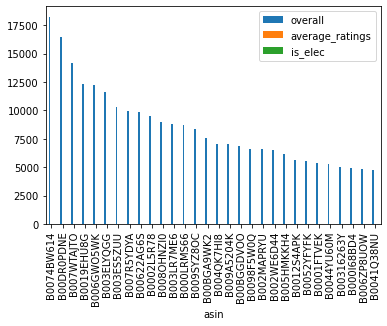

In [117]:
most_popular.head(30).plot(kind = "bar")

# Further data exploration

## Recomend similar items based on count, rating, and unreliability factor (k-nearest neighbors) - Memory based

In [118]:
product_rating = df.groupby('new_product_id')['overall'].mean()
product_rating.head()

new_product_id
0    5.000000
1    1.666667
2    4.500000
3    2.851852
4    3.000000
Name: overall, dtype: float64

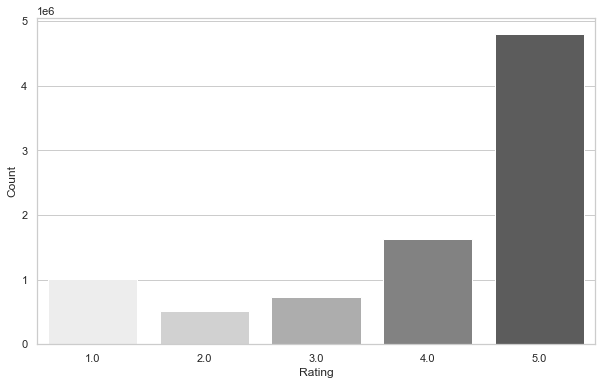

In [120]:
# figure to show proportion for each rating
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
ax = sns.countplot(x='overall', data=df, palette=sns.color_palette('Greys'))
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

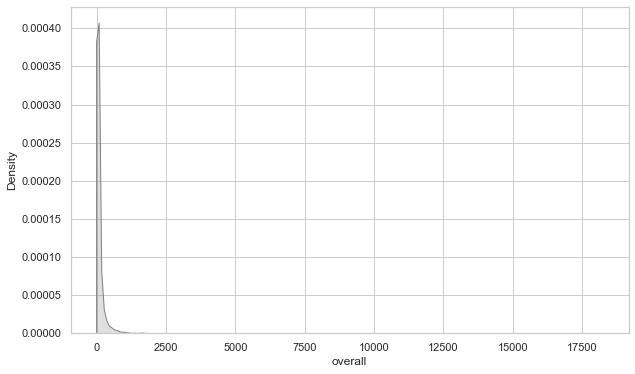

In [121]:
# Count of the number of ratings per Product

product_rating_count = df.groupby('new_product_id')['overall'].count()
ax = sns.kdeplot(product_rating_count, shade=True, color='grey')
plt.show()

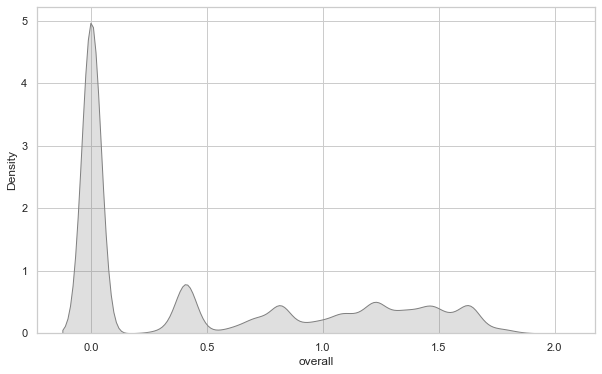

In [123]:
# Un-Reliability factor

unreliability = df.groupby('new_product_id')['overall'].std(ddof = -1)
ax = sns.kdeplot(unreliability, shade=True, color='grey')
plt.show()

In [124]:
unique_products_list = df.new_product_id.unique()
data_model = pd.DataFrame({'rating': product_rating[unique_products_list],\
                           'count': product_rating_count[unique_products_list], \
                          'unreliability': unreliability[unique_products_list]})
data_model.head()

,rating,count,unreliability
new_product_id,,,
0,5.000000,1,0.000000
1,1.666667,3,0.816497
2,4.500000,6,1.035098
3,2.851852,27,1.619164
4,3.000000,1,0.000000


In [125]:
data_model.shape

(662166, 3)

In [126]:
data_model["count"].describe()

count    662166.000000
mean         13.138098
std          97.172003
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max       18244.000000
Name: count, dtype: float64

In [127]:
data_model_new = data_model[data_model["count"] > 10].copy()
print(data_model_new.shape)

(102928, 3)


In [128]:
# Normalization function to range 0 - 10

def normalize(values):
    mn = values.min()
    mx = values.max()
    return(10.0/(mx - mn) * (values - mx)+10)

In [129]:
data_model_norm = normalize(data_model_new)
data_model_norm.head()

,rating,count,unreliability
new_product_id,,,
3,4.629630,0.008775,8.344982
10,8.833333,0.002194,5.110753
17,8.392857,0.001645,6.129190
20,8.064516,0.010969,6.273896
21,8.461538,0.001097,6.323741


In [130]:
# Setting up the model

# Recommend 10 similar items
engine = KNeighborsClassifier(n_neighbors=10)

# Training data points
data_points = data_model_norm[['count', 'rating', 'unreliability']].values

#Training labels
labels = data_model_norm.index.values

print("Data points: ")
print(data_points)
print("Labels: ")
print(labels)

engine.fit(data_points, labels)

Data points: 
[[8.77529754e-03 4.62962963e+00 8.34498194e+00]
 [2.19382438e-03 8.83333333e+00 5.11075255e+00]
 [1.64536829e-03 8.39285714e+00 6.12918953e+00]
 ...
 [1.09691219e-03 5.38461538e+00 6.70461953e+00]
 [6.03301706e-03 6.47727273e+00 7.23447124e+00]
 [0.00000000e+00 5.22727273e+00 3.29643402e+00]]
Labels: 
[     3     10     17 ... 488074 488075 488076]


KNeighborsClassifier(n_neighbors=10)

In [133]:
# Enter product ID to get a list of 10 recommended items

# User entered value
product_id = 477916

product_data = [data_model_norm.loc[product_id][['count', 'rating', 'unreliability']].values]

recommended_products = engine.kneighbors(X=product_data, n_neighbors=10, return_distance=False)

# List of product IDs form the indexes

products_list = []

for each in recommended_products:
    products_list.append(data_model_norm.iloc[each].index)

print("Recommended products: ")
print(products_list)

Recommended products: 
[Int64Index([477916, 85339, 335458, 170288, 84705, 47629, 25766, 422455, 310924,
            404299],
           dtype='int64', name='new_product_id')]


In [134]:
items = df[df['new_product_id'].isin(products_list[0])]
items = items.drop_duplicates(subset=['asin'], keep='last')
items.sort_values(by=['new_product_id'])

,Unnamed: 0,reviewerID,asin,overall,index,is_elec,new_user_id,new_product_id
414023,414023,A23H3IANWX8SUW,B0001YIMAA,3.0,414023,1,339103,25766
791687,791687,A3LBZLI0FOL2YP,B000BZTKNC,2.0,791687,1,31077,47629
1478190,1478190,A3PIVVHEH443CH,B000WBJDUA,3.0,1478190,1,558407,84705
1492721,1492721,A24O9H28AU1I5A,B000WMOIIQ,5.0,1492721,1,1067477,85339
3118965,3118965,A2Y6PFM4U7602H,B0037AGZIG,3.0,3118965,1,1991110,170288
5666825,5666825,AZDT5WJKXP7O7,B0078J7H5M,4.0,5666825,1,3252254,310924
6081766,6081766,A3KKC1IB9ZOI3J,B0085VHQHQ,5.0,6081766,1,3440658,335458
7137400,7137400,A3RMWY5YWZVMST,B00BN5Z2UY,5.0,7137400,1,3911600,404299
7343474,7343474,A2O7RD8T0IAK4N,B00D1O5U84,2.0,7343474,1,2811575,422455
8271859,8271859,A2MK3YPFEDCBV,B00D0HNQR4,5.0,8271859,0,4534298,477916


## Matrix Factorization using Surprise to predict ratings - Model based

In [1]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

import pandas as pd

In [2]:
df = pd.read_csv("elec_fash.csv")
to_read = df[["reviewerID", "asin", "overall"]]
to_read.head()

,reviewerID,asin,overall
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [5]:
to_read["overall"].mean()

4.0015699568784875

In [6]:
len(to_read)

8699602

In [ ]:
# param_grid, n_epochs = 10, lr_all = 0.005, reg_all = 0.4
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(to_read, reader)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [16]:
# param_grid, n_epochs = 10, lr_all = 0.01
param_grid = {'n_epochs': [10, 15], 'lr_all': [0.005, 0.01]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(to_read, reader)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.3011588890164538
{'n_epochs': 10, 'lr_all': 0.01}


In [6]:
# param_grid, reg_all = 0.2
param_grid = {'reg_all': [0.02, 0.2, 0.4]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(to_read, reader)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.294301775290916
{'reg_all': 0.2}


In [3]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(to_read, reader)
svd = SVD(verbose=True, n_epochs=10, lr_all=0.01, reg_all=0.2)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2947  1.2945  1.2946  1.2946  0.0001  
MAE (testset)     1.0335  1.0332  1.0328  1.0332  0.0003  
Fit time          372.58  542.13  297.71  404.14  102.25  
Test time         47.49   88.29   33.33   56.37   23.30   


{'test_rmse': array([1.29470007, 1.29450391, 1.29460028]),
 'test_mae': array([1.03353676, 1.03323308, 1.03282561]),
 'fit_time': (372.58413648605347, 542.1310338973999, 297.70731568336487),
 'test_time': (47.48892164230347, 88.29013419151306, 33.32508587837219)}

In [4]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [9]:
import random

def predict_review(reviewerID, asin, model):
    # Predicts the review (on a scale of 1-5) that a user would assign to a specific product
    
    prediction = model.predict(uid=reviewerID, iid=asin)
    return prediction.est

def generate_recommendation(reviewerID, model, data, thres=4.1):    
    reviewed_product_ids = data[data.reviewerID == reviewerID].asin.values
    potential_product_ids = data[~data.reviewerID.isin(reviewed_product_ids)].asin.unique()
    
    # generate 50 random recommendations with ratings above threshold
    recommendations = {}
    returned_recommendations = []
    random.shuffle(potential_product_ids)
    for product in potential_product_ids:
        rating = predict_review(reviewerID, product, model)
        if rating >= thres and len(recommendations) < 50:
            recommendations[product] = rating
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    for x in range(len(sorted_recommendations)):
        returned_recommendations.append(sorted_recommendations[x][0])
    return returned_recommendations

In [10]:
generate_recommendation("ADLVFFE4VBT8", svd, to_read, thres=4.2)

['B01EOA2RRA',
 'B005WKJR1Q',
 'B001L6EPCQ',
 'B0001W7TXI',
 'B002P7HYSW',
 'B0002821X4',
 'B005Q5EYOW',
 'B009924AXS',
 'B00KD8QTPE',
 'B000FCQ2WS',
 'B007BFG0YM',
 'B007S7JCUC',
 'B005943FUO',
 'B009EAPIWW',
 'B0009O5SZE',
 'B00KH9F76G',
 'B000GU8AJ2',
 'B0032GMS18',
 'B00K8AIWF2',
 'B00411M62Y',
 'B005F79F90',
 'B00SSARR50',
 'B008XIL7XU',
 'B00J0ARMTS',
 'B01GBXUH9S',
 'B0054LBB6M',
 'B01B9RAGDS',
 'B003M17WWI',
 'B00608J69C',
 'B00E4OI5H8',
 'B008TB1X58',
 'B009JHI3TA',
 'B00NR61U7Q',
 'B0016P3XMU',
 'B0054HJ3BG',
 'B00ARXRPMG',
 'B0009WOMHQ',
 'B0096DLEGG',
 'B005CX51TA',
 'B000H7LVC2',
 'B009A6CXCI',
 'B00874U3K8',
 'B01DH10648',
 'B005HB882E',
 'B004V1RQQK',
 'B004CHQ7PO',
 'B005WEJBAY',
 'B0002ZPIQ4',
 'B00009XV1E',
 'B0054I9JI2']

In [10]:
df.head()

,Unnamed: 0,reviewerID,asin,overall,index,is_elec,new_user_id,new_product_id
0,0,A2CX7LUOHB2NDG,0321732944,5.0,0,1,0,0
1,1,A2NWSAGRHCP8N5,0439886341,1.0,1,1,1,1
2,2,A2WNBOD3WNDNKT,0439886341,3.0,2,1,2,1
3,3,A1GI0U4ZRJA8WN,0439886341,1.0,3,1,3,1
4,4,A1QGNMC6O1VW39,0511189877,5.0,4,1,4,2


In [8]:
# most active users and their average ratings

active_users = pd.DataFrame(df.groupby('reviewerID')['overall'].count())
active_users_ratings = pd.DataFrame(df.groupby('reviewerID')['overall'].mean())
active_users["average_ratings"] = active_users_ratings["overall"]
active_users_number_elect = pd.DataFrame(df.groupby('reviewerID')['is_elec'].count().astype(int))
active_users["number_elec"] = active_users_number_elect["is_elec"]
most_active_users = active_users.sort_values('overall', ascending=False)

In [9]:
most_active_users.head(10)

,overall,average_ratings,number_elec
reviewerID,,,
A5JLAU2ARJ0BO,521,3.863724,521
ADLVFFE4VBT8,507,4.276134,507
A3OXHLG6DIBRW8,499,4.450902,499
A6FIAB28IS79,433,4.187067,433
A680RUE1FDO8B,406,4.406404,406
A1ODOGXEYECQQ8,380,4.305263,380
A36K2N527TXXJN,314,4.525478,314
A2AY4YUOX2N1BQ,311,4.559486,311
AWPODHOB4GFWL,310,4.396774,310


In [31]:
df[df["reviewerID"]=="ADLVFFE4VBT8"]

,Unnamed: 0,reviewerID,asin,overall,index,is_elec,new_user_id,new_product_id
5931,5931,ADLVFFE4VBT8,9981719005,3.0,5931,1,5855,605
31764,31764,ADLVFFE4VBT8,B00002NDRF,4.0,31764,1,5855,2547
78563,78563,ADLVFFE4VBT8,B00005114Z,5.0,78563,1,5855,5574
133612,133612,ADLVFFE4VBT8,B00006343P,2.0,133612,1,5855,8895
154285,154285,ADLVFFE4VBT8,B000067RVL,5.0,154285,1,5855,9929
...,...,...,...,...,...,...,...,...
8165047,8165047,ADLVFFE4VBT8,B01A3VP1B8,4.0,8165047,0,5855,485959
8360597,8360597,ADLVFFE4VBT8,B00MJXI1CA,3.0,8360597,0,5855,535054
8391086,8391086,ADLVFFE4VBT8,B00PAK31BK,5.0,8391086,0,5855,545040
8441146,8441146,ADLVFFE4VBT8,B00VPRJX9G,5.0,8441146,0,5855,482639


In [30]:
df[df["reviewerID"]=="ADLVFFE4VBT8"]["asin"].iloc[0]

'9981719005'

In [32]:
items = []
for x in range(507):
    items.append(df[df["reviewerID"]=="ADLVFFE4VBT8"]["asin"].iloc[x])

In [41]:
check = [('B002SEKD5I', 4.813262369905649),
 ('B000O8E8YW', 4.7591201075438),
 ('B005H3EBOG', 4.755868205558532),
 ('B000B8MVQC', 4.631437857506977),
 ('B009S0D1KE', 4.568290291076841),
 ('B004BHA5XA', 4.489988622883673),
 ('B00ZGTZ97E', 4.42576912357422),
 ('B000BD8FX0', 4.405713345904505),
 ('B0046TTF5M', 4.399031527346594),
 ('B00AMY1OB8', 4.3729065041370125),
 ('B001NVIKS4', 4.369341228910344),
 ('B003MQLSQE', 4.359818452539673),
 ('B01FPMVGEG', 4.350851574946926),
 ('B005OQHA5I', 4.346657634446212),
 ('B00AEIQ4R6', 4.335762064048384),
 ('B006VOT7U8', 4.329746501114378),
 ('B00005I9S2', 4.3197271753247595),
 ('B003E439GG', 4.294471131013783),
 ('B019IHWO2W', 4.287143218814241),
 ('B002K00J0E', 4.279957282028125)]

In [47]:
for i in range(len(check)):
    check_item = check[i][0]
    print(check_item in items)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
